Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt

Collecting Data

In [3]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
time_period = 5
price = stock.history(period=f'{time_period}y')

Analysing data

In [4]:
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-11-26 00:00:00-05:00 to 2024-11-26 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.7 KB


In [5]:
price.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000
mean,148.821164,150.472538,147.288247,148.961133,9.171762e+07,0.003592,0.003177
std,41.607506,41.816736,41.388341,41.622194,5.321522e+07,0.028363,0.112732
min,55.411093,55.513129,51.652720,54.509762,1.079301e+07,0.000000,0.000000
25%,124.651376,125.760817,123.458986,124.461788,5.655270e+07,0.000000,0.000000
50%,148.717732,150.337062,147.092332,149.131470,7.733480e+07,0.000000,0.000000
75%,175.338869,177.004860,173.718991,175.461586,1.089385e+08,0.000000,0.000000
max,235.947003,237.229001,234.192340,236.220108,4.265100e+08,0.250000,4.000000


Visualising Data

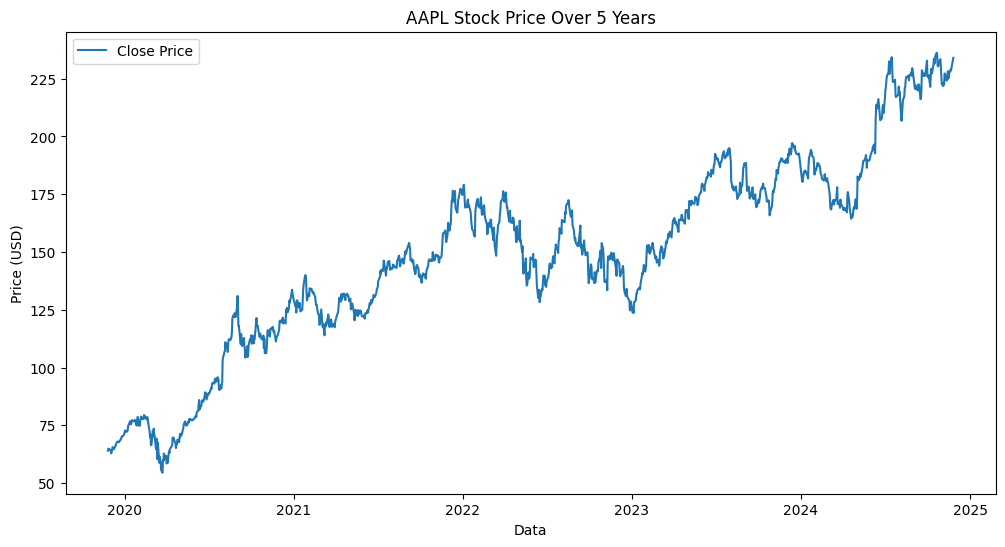

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(price['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price Over {time_period} Years')
plt.xlabel('Data')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Handling missing values

In [7]:
price.ffill(inplace=True)

Normalizing the Data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
price_scaled = scaler.fit_transform(price[['Open', 'High', 'Low', 'Close', 'Volume']])

Preparing data for time series prediction

In [9]:
def create_sequences(data, time_steps):
    X,y=[],[]
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 3])
    return np.array(X), np.array(y)

In [10]:
time_steps=60
X, y = create_sequences(price_scaled, time_steps)

Train Test split

In [11]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Reshaping the data for LSTM model

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],  X_test.shape[1], X_test.shape[2]))

Building the LSTM model

In [13]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2024-11-26 20:44:36.873186: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/nishant/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,905 (1.27 MB)

 Trainable params: 331,905 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stop], verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0560 - val_loss: 0.0138
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0057 - val_loss: 0.0127
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0039 - val_loss: 0.0065
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 209

Visualising Training Loss

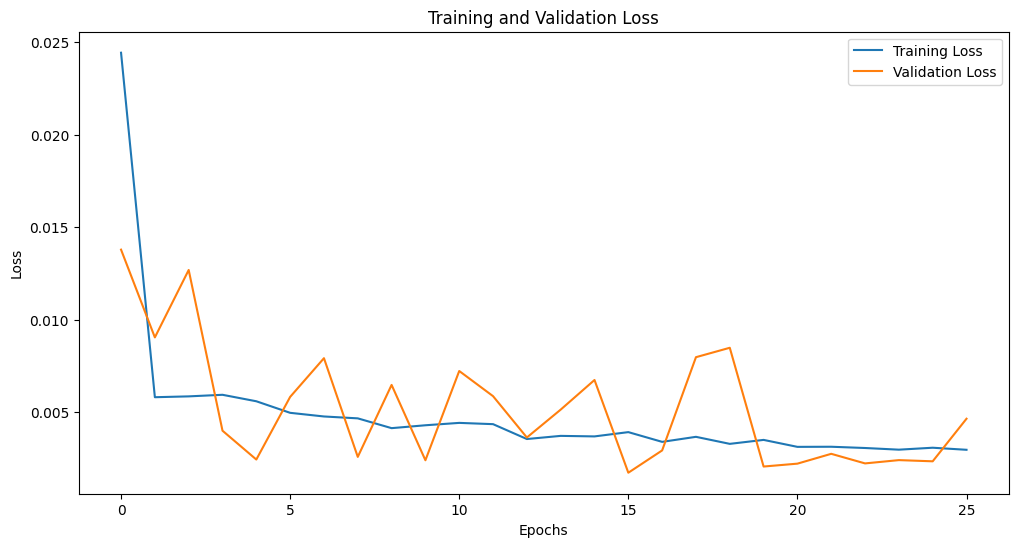

In [15]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluating the model

In [16]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
test_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017


0.0017268856754526496

Making Predictions

In [17]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform([[0,0,0,pred,0] for pred in y_pred.flatten()])[:,3]
y_test_actual = scaler.inverse_transform([[0,0,0,pred,0] for pred in y_test.flatten()])[:,3]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


Visualising Predictions vs Actual Prices

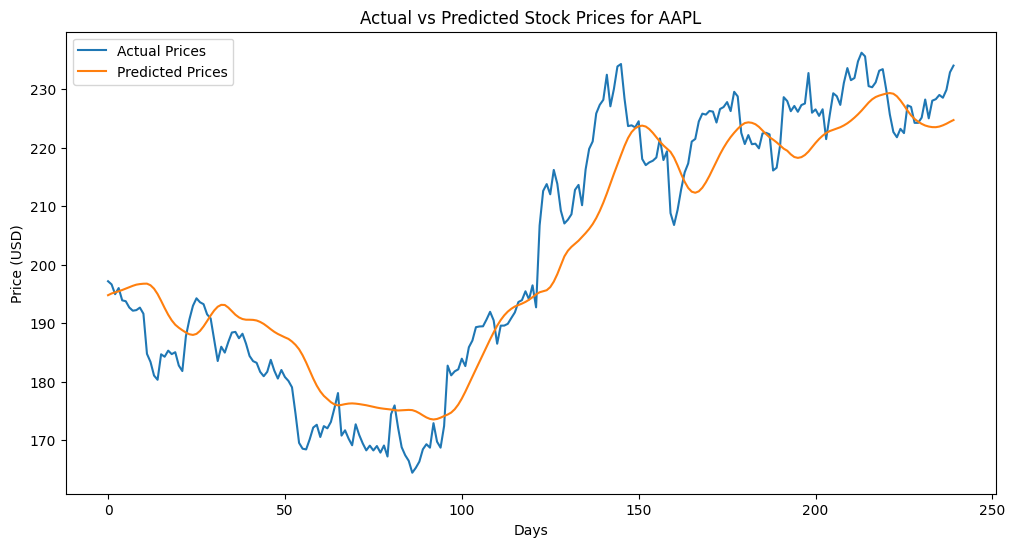

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title(f'Actual vs Predicted Stock Prices for {ticker}')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [19]:
model.save('lstm_stock_model.h5')

In [20]:
rmse = sqrt(test_loss)

In [21]:
rmse

0.041555813978944624